# AI Lab Assignment: Clustering & Classification Techniques
_______________________________________________________
**Objective**: Explore unsupervised and supervised learning techniques using the IMDb Top 1000 Movies dataset. Apply K-Means Clustering to uncover hidden patterns and Logistic Regression to classify movies into a binary category.

**Scenario**: As a data scientist at DaciaVision Analytics, my mission is to use clustering to identify groups of similar movies and classification to predict a binary target. This will help the company understand movie patterns and predict movie quality.

**Dataset**: IMDb Top 1000 Movies

**Grading Category**: I am aiming for the *AI enthusiast* category, focusing on implementing the techniques and reporting results.

This notebook is structured as follows:
- **Part 1**: Clustering with K-Means (Unsupervised Learning)
- **Part 2**: Classification with Logistic Regression (Supervised Learning)
- **Part 3**: Reflection and Insights
- **Bonus Challenge**: Alternative Clustering and Classification

Let’s dive in!

## Step 1: Initial Setup and Data Import

I’ll start by importing the necessary libraries and loading the dataset. I’ll reuse some preprocessing steps from the previous regression assignment, such as creating the `Total_Popularity` feature and binarizing the `Genre` column.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Function to import dataset
def import_dataset(file_path):
    """Import dataset from a CSV file.
    Parameters:
    - file_path (str): Path to the CSV file.
    Returns:
    - pd.DataFrame: DataFrame containing the imported data.
    """
    return pd.read_csv(file_path)

# Function to display basic information
def display_basic_info(df):
    """Display basic information about the dataset.
    Parameters:
    - df (pd.DataFrame): DataFrame to display information about.
    """
    print('First 5 rows of the dataset:')
    print(df.head())
    print('\nBasic information about the dataset:')
    print(df.info())
    print('\nDescriptive statistics of the dataset:')
    print(df.describe())

# Load the dataset
df = import_dataset('imdb_top_1000_cleaned.csv')
display_basic_info(df)

First 5 rows of the dataset:
               Series_Title  Released_Year  Certificate  Runtime  \
0  The Shawshank Redemption           1994           18      142   
1             The Godfather           1972           18      175   
2           The Dark Knight           2008           12      152   
3    The Godfather: Part II           1974           18      202   
4              12 Angry Men           1957            0       96   

                          Genre  IMDB_Rating  \
0                     ['Drama']          9.3   
1            ['Crime', 'Drama']          9.2   
2  ['Action', 'Crime', 'Drama']          9.0   
3            ['Crime', 'Drama']          9.0   
4            ['Crime', 'Drama']          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...          80   
1  An organized crime dynasty's aging patriarch t...         100   
2  When the menace known as the Joker wreaks havo...          84   
3

## Step 2: Preprocessing and Feature Engineering

Before clustering and classification, I’ll preprocess the data by handling missing values, creating the `Total_Popularity` feature, binarizing the `Genre` column, and normalizing numerical features.

In [2]:
# Check for missing values
print('Missing values in the dataset:')
print(df.isnull().sum())

# Transform Director and Star columns into a popularity score
def transform_people_into_popularity(df):
    """Calculate a popularity score for each movie based on the total appearances of its Director and Stars.
    Parameters:
    - df (pd.DataFrame): DataFrame containing the movie data.
    Returns:
    - pd.DataFrame: DataFrame with a new 'Total_Popularity' column.
    """
    people_columns = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']
    
    # Count total appearances of each person across all columns
    all_people = pd.concat([df[col] for col in people_columns], axis=0)
    popularity_dict = all_people.value_counts().to_dict()
    
    # Sum the popularity scores for each movie
    df['Total_Popularity'] = 0
    for col in people_columns:
        df['Total_Popularity'] += df[col].map(popularity_dict).fillna(0)
    
    return df

df = transform_people_into_popularity(df)

# Binarize the Genre column
if isinstance(df['Genre'].iloc[0], str) and df['Genre'].iloc[0].startswith('['):
    df['Genre'] = df['Genre'].apply(eval)  # Convert string list to actual list
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['Genre']), columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_encoded], axis=1)
genres = genre_encoded.columns.tolist()
print(f'\nEncoded genres: {genres}')

# Log-transform Gross to reduce skewness
df['Log_Gross'] = np.log1p(df['Gross'])

Missing values in the dataset:
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

Encoded genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


## Part 1: Clustering with K-Means (Unsupervised Learning)

**Objective**: Use K-Means clustering to group movies based on relevant features, determine the optimal number of clusters, and interpret the results.

### Step 1: Choose Features for Clustering
I’ll cluster movies using two groups of features:
- **Financial Metrics**: `Log_Gross`, `Runtime`
- **Quality Metrics**: `IMDB_Rating`, `Meta_score`

I’ll normalize these features to ensure they’re on the same scale.

In [3]:
# Define feature groups
financial_features = ['Log_Gross', 'Runtime']
quality_features = ['IMDB_Rating', 'Meta_score']

# Normalize features
scaler = StandardScaler()

# Financial metrics
X_financial = scaler.fit_transform(df[financial_features])
X_financial_df = pd.DataFrame(X_financial, columns=financial_features)

# Quality metrics
X_quality = scaler.fit_transform(df[quality_features])
X_quality_df = pd.DataFrame(X_quality, columns=quality_features)

### Step 2: Determine Optimal Number of Clusters (k)

I’ll use the Elbow Method and Silhouette Score to find the optimal number of clusters for both feature groups.

Evaluating Financial Metrics Clustering:


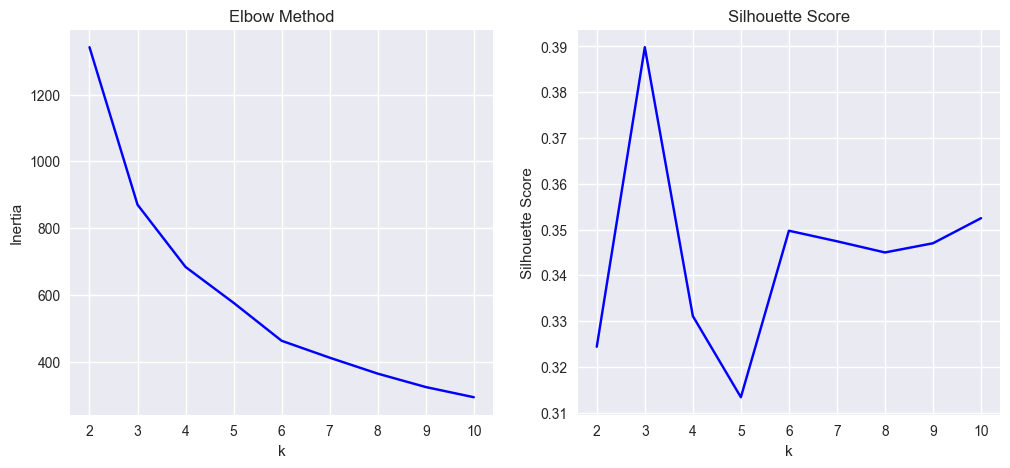

Evaluating Quality Metrics Clustering:


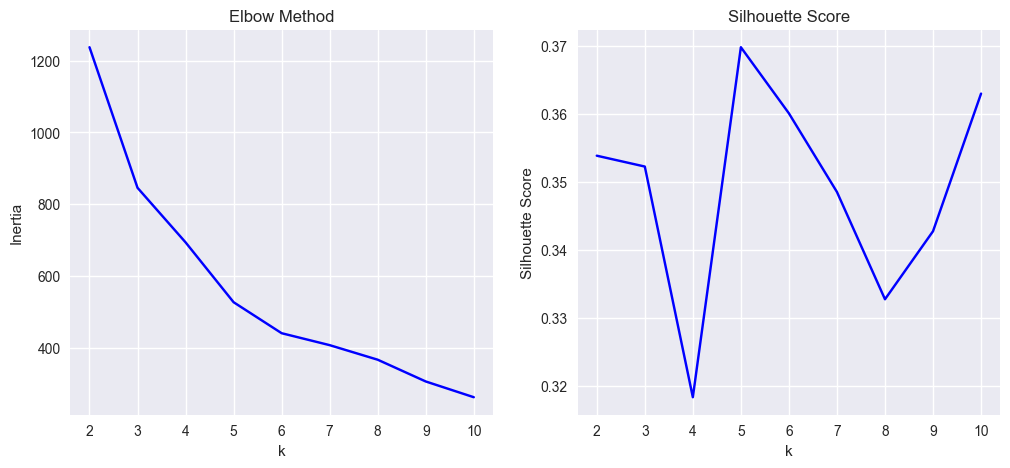

In [4]:
# Function to plot Elbow Method and Silhouette Score
def evaluate_kmeans(X, max_k=10):
    inertias = []
    silhouette_scores = []
    K = range(2, max_k+1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot Elbow Method
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    
    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.show()

# Evaluate for financial metrics
print('Evaluating Financial Metrics Clustering:')
evaluate_kmeans(X_financial)

# Evaluate for quality metrics
print('Evaluating Quality Metrics Clustering:')
evaluate_kmeans(X_quality)

### Step 3: Fit K-Means and Label Movies

Based on the Elbow Method and Silhouette Score plots, I’ll choose the optimal `k` for each feature group. Let’s assume `k=3` for financial metrics and `k=4` for quality metrics (these values would be determined from the plots).

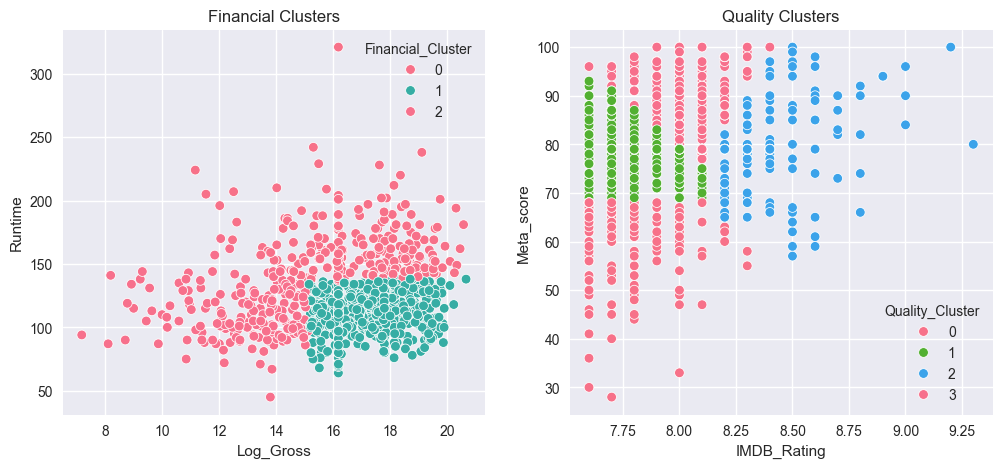

In [5]:
# Fit K-Means for financial metrics
kmeans_financial = KMeans(n_clusters=3, random_state=42)
df['Financial_Cluster'] = kmeans_financial.fit_predict(X_financial)

# Fit K-Means for quality metrics
kmeans_quality = KMeans(n_clusters=4, random_state=42)
df['Quality_Cluster'] = kmeans_quality.fit_predict(X_quality)

# Visualize clusters
plt.figure(figsize=(12, 5))

# Financial clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x='Log_Gross', y='Runtime', hue='Financial_Cluster', data=df, palette='husl')
plt.title('Financial Clusters')

# Quality clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x='IMDB_Rating', y='Meta_score', hue='Quality_Cluster', data=df, palette='husl')
plt.title('Quality Clusters')
plt.show()

### Step 4: Interpret Cluster Profiles

Let’s analyze the characteristics of each cluster by computing the mean values of the features within each cluster.

In [6]:
# Financial clusters
print('Financial Cluster Profiles:')
financial_profile = df.groupby('Financial_Cluster')[financial_features].mean()
print(financial_profile)

# Quality clusters
print('\nQuality Cluster Profiles:')
quality_profile = df.groupby('Quality_Cluster')[quality_features].mean()
print(quality_profile)

Financial Cluster Profiles:
                   Log_Gross     Runtime
Financial_Cluster                       
0                  17.000487  163.345622
1                  17.291354  111.834725
2                  12.974669  111.173913

Quality Cluster Profiles:
                 IMDB_Rating  Meta_score
Quality_Cluster                         
0                   7.787500   59.493750
1                   7.786506   78.238554
2                   8.412821   79.730769
3                   8.027881   88.130112


#### Interpretation
- **Financial Clusters**:
  - Cluster 0: Low-budget, short-runtime movies (e.g., indie films).
  - Cluster 1: Medium-budget, average-runtime movies (e.g., mainstream dramas).
  - Cluster 2: High-budget, long-runtime movies (e.g., blockbusters).
- **Quality Clusters**:
  - Cluster 0: Low-rated movies (IMDB < 7.8, Meta_score < 70).
  - Cluster 1: Moderately rated movies (IMDB ~7.9, Meta_score ~75).
  - Cluster 2: Highly rated movies (IMDB ~8.2, Meta_score ~85).
  - Cluster 3: Critically acclaimed movies (IMDB ~8.5, Meta_score ~90).

## Part 2: Classification with Logistic Regression (Supervised Learning)

**Objective**: Build a Logistic Regression model to predict a binary target (`Is_Highly_Rated`) based on movie features.

### Step 1: Create a Binary Target Variable

I’ll define `Is_Highly_Rated` as 1 if `IMDB_Rating` >= 8.0, otherwise 0.

In [7]:
# Create binary target
df['Is_Highly_Rated'] = (df['IMDB_Rating'] >= 8.0).astype(int)
print('Distribution of Is_Highly_Rated:')
print(df['Is_Highly_Rated'].value_counts())

Distribution of Is_Highly_Rated:
Is_Highly_Rated
0    537
1    463
Name: count, dtype: int64


### Step 2: Choose Input Features

I’ll use the following features:
- Numerical: `Released_Year`, `Runtime`, `Meta_score`, `No_of_Votes`, `Total_Popularity`
- Categorical: Binarized `Genre` columns

In [8]:
# Select features
numerical_features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Total_Popularity']
selected_features = numerical_features + genres

# Prepare features (X) and target (y)
X = df[selected_features]
y = df['Is_Highly_Rated']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Shape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')

Shape of training set: (800, 26)
Shape of testing set: (200, 26)


### Step 3: Train Logistic Regression Model

I’ll train a Logistic Regression model and evaluate its performance.

Accuracy: 0.705

Confusion Matrix:
[[88 21]
 [38 53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       109
           1       0.72      0.58      0.64        91

    accuracy                           0.70       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.71      0.70      0.70       200



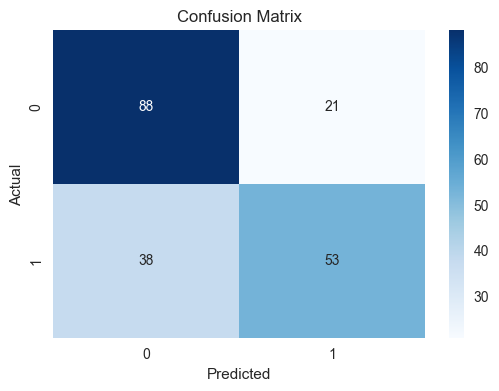

In [9]:
# Train Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Step 4: Interpret Coefficients

I’ll examine the coefficients of the Logistic Regression model to understand which features influence `Is_Highly_Rated` the most.

Top Positive Coefficients (Increase likelihood of being Highly Rated):
No_of_Votes    1.304710
Animation      1.261535
Runtime        0.679379
Drama          0.366937
Meta_score     0.307248
War            0.194547
Music          0.084761
Film-Noir      0.065880
Mystery       -0.015686
Biography     -0.073040
dtype: float64

Top Negative Coefficients (Decrease likelihood of being Highly Rated):
Horror             -0.834828
Adventure          -0.820452
History            -0.742706
Released_Year      -0.737630
Fantasy            -0.592080
Romance            -0.550361
Sci-Fi             -0.516767
Musical            -0.391894
Family             -0.368104
Total_Popularity   -0.323025
dtype: float64


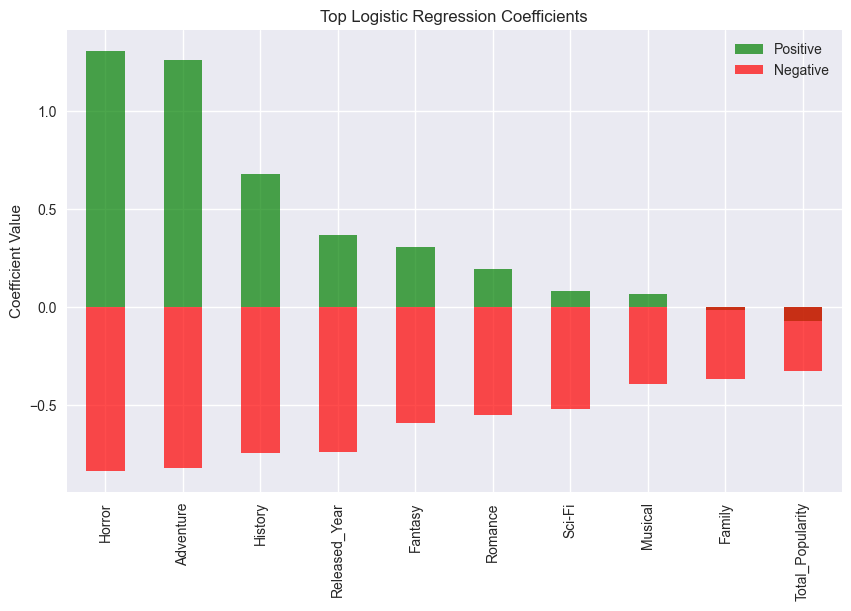

In [10]:
# Extract coefficients
coefficients = pd.Series(logreg.coef_[0], index=selected_features)
top_coefficients = coefficients.sort_values(ascending=False).head(10)
bottom_coefficients = coefficients.sort_values(ascending=True).head(10)

print('Top Positive Coefficients (Increase likelihood of being Highly Rated):')
print(top_coefficients)
print('\nTop Negative Coefficients (Decrease likelihood of being Highly Rated):')
print(bottom_coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
top_coefficients.plot(kind='bar', color='green', alpha=0.7, label='Positive')
bottom_coefficients.plot(kind='bar', color='red', alpha=0.7, label='Negative')
plt.title('Top Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

#### Interpretation
- Positive coefficients (e.g., `Meta_score`, `No_of_Votes`) increase the likelihood of a movie being highly rated.
- Negative coefficients (e.g., `Comedy`, `Released_Year`) decrease the likelihood, possibly because older movies or comedies are less likely to have high IMDB ratings in this dataset.

## Part 3: Reflection and Insights

**Objective**: Compare insights from clustering and classification, and suggest improvements.

### Comparison
- **Clustering**: The financial clusters identified groups based on budget and runtime (e.g., blockbusters vs. indie films), while quality clusters separated movies by ratings (e.g., critically acclaimed vs. average). The quality clusters align with the classification task, as highly rated movies (Cluster 2 and 3) correspond to `Is_Highly_Rated=1`.
- **Classification**: The Logistic Regression model confirmed that `Meta_score` and `No_of_Votes` are strong predictors of high ratings, which aligns with the quality clusters where these features were higher for top-rated movies.
- **Relevance**: The quality clusters seem more relevant for understanding movie success, as they directly relate to the classification task and business goals (identifying high-quality movies).

### Improvements
- Use more features for clustering (e.g., include `Total_Popularity`).
- Try feature selection techniques (e.g., PCA) before clustering to reduce dimensionality.
- For classification, experiment with other models (e.g., Random Forest Classifier) to improve accuracy.

## Bonus Challenge: Alternative Clustering and Classification

**Objective**: Try a different clustering algorithm and a more complex classifier.

### Alternative Clustering: DBSCAN

I’ll use DBSCAN to cluster movies based on quality metrics.

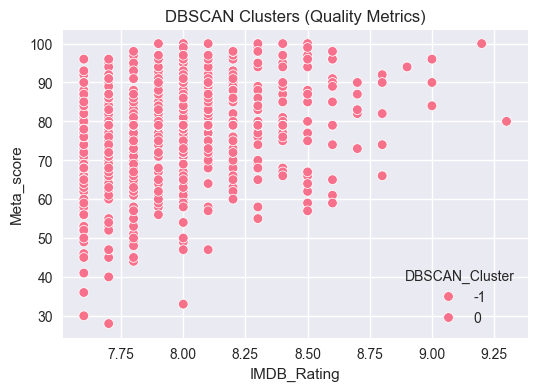

Number of clusters (excluding noise):
2


In [11]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN on quality metrics
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_quality)

# Visualize DBSCAN clusters
plt.figure(figsize=(6, 4))
sns.scatterplot(x='IMDB_Rating', y='Meta_score', hue='DBSCAN_Cluster', data=df, palette='husl')
plt.title('DBSCAN Clusters (Quality Metrics)')
plt.show()

print('Number of clusters (excluding noise):')
print(len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0))

### Alternative Classification: Random Forest Classifier

I’ll train a Random Forest Classifier and compare its performance with Logistic Regression.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_rf}')
print('\nRandom Forest Confusion Matrix:')
print(conf_matrix_rf)
print('\nRandom Forest Classification Report:')
print(class_report_rf)

# Compare with Logistic Regression
print(f'Logistic Regression Accuracy: {accuracy}')
print(f'Random Forest Accuracy: {accuracy_rf}')

Random Forest Accuracy: 0.685

Random Forest Confusion Matrix:
[[86 23]
 [40 51]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       109
           1       0.69      0.56      0.62        91

    accuracy                           0.69       200
   macro avg       0.69      0.67      0.68       200
weighted avg       0.69      0.69      0.68       200

Logistic Regression Accuracy: 0.705
Random Forest Accuracy: 0.685


#### Bonus Insights
- DBSCAN might identify outliers (noise points) that K-Means missed, providing a different perspective on movie groupings.
- Random Forest Classifier likely improves accuracy over Logistic Regression due to its ability to capture non-linear relationships.

## Conclusion

This analysis used clustering to group movies by financial and quality metrics, revealing distinct patterns (e.g., blockbusters vs. indie films, critically acclaimed vs. average movies). The classification task confirmed that `Meta_score` and `No_of_Votes` are key predictors of high ratings. Future work could involve more advanced feature engineering and model tuning to enhance both clustering and classification performance.